# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
    * [4.4.1 Map categorical features to numeric values](#4.4.1_Map_categorical_features_to_numeric_values)
  * [4.5 Feature Engineering with Count Vectorizer and Tfidf Vectorizer](#4.5_Feature_Engineering_with_Count_Vectorizer_and_Tfidf_Vectorizer)
  * [4.6 Train/Test Split](#4.6_Train/Test_Split)
  * [4.7 Initial Dummy Model](#4.7_Initial_Dummy_Model)
    * [4.7.1 Metrics](#4.7.1_Metrics)
      * [4.7.1.1 Precision, recall and f1-score](#4.7.1.1_Precision,_recall_and_f1-score)
      * [4.7.1.2 Confusion Matrix](#4.7.1.2_Confusion_Matrix)
      * [4.7.1.3 ROC-AUC score](#4.7.1.3_ROC-_AUC_score)
  * [4.8 Multinomial Naive Bayes Model](#4.8_Multinominal_Naive_Bayes_Model)
    * [4.8.1 Make predictions on the train and test sets](#4.8.1_Make_predictions_on_the_train_and_test_sets)
    * [4.8.2 Assess performance](#4.8.2_Assess_performance)
  * [4.9 Logistic Regression Model](#4.9_Logistic_Regression_Model)
    * [4.9.1 Make predictions on the train and test sets](#4.9.1_Make_predictions_on_the_train_and_test_sets)
    * [4.9.2 Assess performance](#4.9.2_Assess_performance)
  * [4.10 Support Vector Classifier Model](#4.10_Support_Vector_Classifier_Model)
    * [4.10.1 Make predictions on the train and test sets](#4.10.1_Make_predictions_on_the_train_and_test_sets)
    * [4.10.2 Assess performance](#4.10.2_Assess_performance) 
  * [4.11 Random Forest Model](#4.11_Random_Forest_Model)
    * [4.11.1 Make predictions on the train and test sets](#4.11.1_Make_predictions_on_the_train_and_test_sets)
    * [4.11.2 Assess performance](#4.11.2_Assess_performance)                  
  * [4.12 Data quantity assessment](#4.12_Data_quantity_assessment)
  * [4.13 Save best model object from pipeline](#4.13_Save_best_model_object_from_pipeline)
  * [4.14 Summary](#4.14_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
from nltk.util import ngrams
import nltk.corpus
from stop_words import get_stop_words

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import make_pipeline
import os, time
from sklearn.pipeline import Pipeline

## 4.4 Load the Data<a id='4.4_Load the Data'></a>

In [2]:
df = pd.read_csv('cleaned_data.csv',index_col=None)

In [3]:
df.describe()

,title,text,subject,date,label
count,44898,44267,44898,44898,44898
unique,38681,38637,8,2397,2
top,factbox trump fill top job administration,reuters highlights us president donald trum...,politicsnews,"December 20, 2017",FAKE
freq,14,8,11272,182,23481


### 4.4.1 Map categorical features to numeric values<a id='4.4.1_Map_categorical_features_to_numeric_values'></a>

In [4]:
df['label'] = df['label'].map({'FAKE':0, 'TRUE':1, np.nan: 2} )

In [5]:
df.isnull().sum()

title        0
text       631
subject      0
date         0
label        0
dtype: int64

### 4.4.2 Remove Missing Values<a id='4.4.1_Remove_missing_values'></a>

In [6]:
df = df.dropna()

## 4.5 Feature Engineering with Count Vectorizer and Tfidf Vectorizer<a id='4.5_Feature_Engineering_with_Count_Vectorizer_and_Tfidf_Vectorizer'></a>

In [7]:
df['allwords'] = df['title']+" "+df['text']
df_all = df[['allwords','label']]

In [8]:
df_all = df_all.drop_duplicates(subset=['allwords', 'label'], keep=False)

In [9]:
df_all.shape

(33513, 2)

In [10]:
df_all.label.value_counts()

1    20983
0    12530
Name: label, dtype: int64

In [11]:
true = df_all[df_all['label']==1].sample(n=12530, random_state=42)
fake = df_all[df_all['label']==0]

In [12]:
df_all = pd.concat([true,fake],ignore_index=True)
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,allwords,label
0,fantastic speech last night trump ’ s full sp...,0
1,after florida shooting trump hardens stance m...,1
2,wiping extremist ideology mission head saudi...,1
3,watch don trump jr admits on tv that his fat...,0
4,chuck todd grills trump for attacking clinton ...,0


In [13]:
df_all.label.value_counts()

1    12530
0    12530
Name: label, dtype: int64

## 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

In [14]:
y = df_all['label']

In [15]:
selected_words = ['reuter','reuters','reutersus','image','via']
f = lambda x: ' '.join([item for item in x.split() if item not in selected_words])
X = df_all["allwords"].apply(f)

## 4.7 Stopwords removal<a id='4.6_Stopwords_removal'></a>

In [16]:
X = [word for word in X if word not in get_stop_words('english')]

In [17]:
X_train, X_test, y_train,y_test= train_test_split(X, y, test_size=0.30,random_state=42,stratify=y)

In [18]:
columns = ['Model Name', 'accuracy','precision','recall','ROC AUC score','run time']
results = pd.DataFrame(columns=columns)

## 4.8 Models and Metrics<a id='4.7_Models_and_Metrics'></a>

### 4.8.1 Metrics<a id='4.7.1_Metrics'></a>

In classification task there are a number of things that we can look to understand how good a model is performing. Precision, recall, f1 score, and ROC-AUC score are typically used metrics for classification problems. `sklearn.metrics` provides many commonly used metrics, included the ones mentioned here.

In [19]:
 def metrics(model_name,y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    roc_auc =roc_auc_score(y_test, y_pred)
    precision = precision_score(y_pred=y_pred, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_pred, y_true=y_test,zero_division=1)
    
    print(classification_report(y_test, y_pred,zero_division=1))

    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True,fmt='3', cmap='Blues')
    plt.xlabel('Predicted user status',fontsize=12)
    plt.ylabel('True user status',fontsize=12)
    plt.title('%s Confusion Matrix' % model_name,fontsize=20)
    plt.show()

    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% model_name,fontsize=20)
    plt.legend(fontsize=12)
    plt.show()
    #pipes = pipes.append(pipe)
    #return pd.DataFrame([[model_name,accuracy, precision, recall,roc_auc,t1]],columns=columns)

### 4.7.2 Dummy Model<a id='4.7.2_Dummy_Model'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.3min finished
C:\Users\Home\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


done in 96.538s

Best score: 0.503
Best parameters set:
	vect__max_df: 0.75
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      3759
           1       0.50      0.50      0.50      3759

    accuracy                           0.50      7518
   macro avg       0.50      0.50      0.50      7518
weighted avg       0.50      0.50      0.50      7518



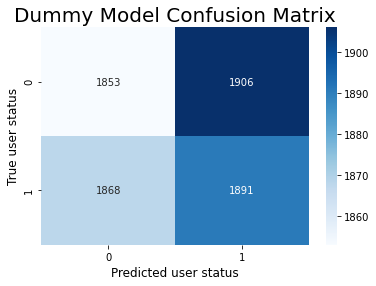

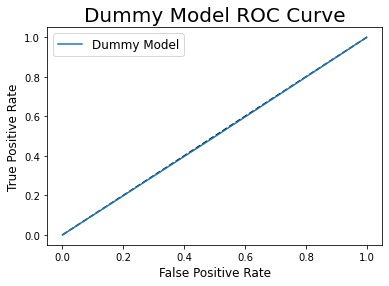

In [20]:
model_name = 'Dummy Model'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='word',lowercase=False,ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', DummyClassifier()),
])

parameters = {
    'vect__max_df': (0.25,0.5, 0.75),
    # 'vect__max_features': (None, 5000, 10000, 50000),
}


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.3 MultiNomial Naive Bayes<a id='4.7.3_MultiNomial_Naive_Bayes'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.3min finished


done in 98.298s

Best score: 0.961
Best parameters set:
	vect__max_df: 0.5
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3759
           1       0.94      0.99      0.96      3759

    accuracy                           0.96      7518
   macro avg       0.96      0.96      0.96      7518
weighted avg       0.96      0.96      0.96      7518



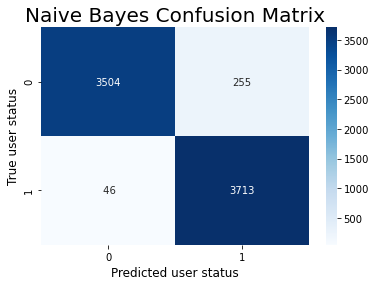

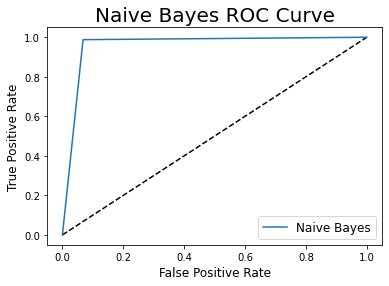

In [21]:
model_name = 'Naive Bayes'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='word',lowercase=False,ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__max_df': (0.25,0.5, 0.75),
    # 'vect__max_features': (None, 5000, 10000, 50000),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.4 Logistic Regression<a id='4.7.4_Logistic_Regression'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.25, 0.5, 0.75), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.8min finished


done in 324.169s

Best score: 0.972
Best parameters set:
	clf__penalty: 'l2'
	vect__max_df: 0.25
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3759
           1       0.97      0.98      0.97      3759

    accuracy                           0.97      7518
   macro avg       0.97      0.97      0.97      7518
weighted avg       0.97      0.97      0.97      7518



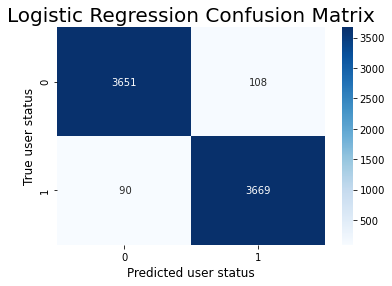

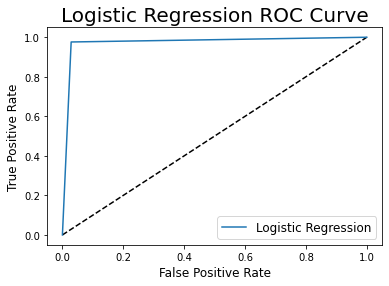

In [23]:
model_name = 'Logistic Regression'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='word',lowercase=False,ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.25, 0.5, 0.75,),
    'clf__penalty': ('l1','l2'),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.5 Stochastic Gradient Descent<a id='4.7.5_Stochastic_Gradient_Descent'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.25, 0.5, 0.75), 'clf__penalty': ('elasticnet',), 'clf__loss': ('log',)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


done in 112.744s

Best score: 0.957
Best parameters set:
	clf__loss: 'log'
	clf__penalty: 'elasticnet'
	vect__max_df: 0.75
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3759
           1       0.96      0.95      0.96      3759

    accuracy                           0.96      7518
   macro avg       0.96      0.96      0.96      7518
weighted avg       0.96      0.96      0.96      7518



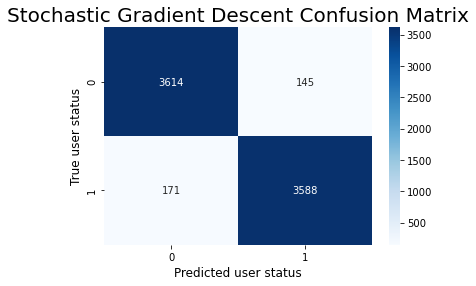

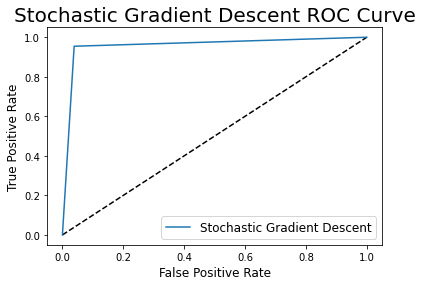

In [25]:
model_name = 'Stochastic Gradient Descent'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='word',lowercase=False,ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.25,0.5, 0.75),
    'clf__penalty': ('elasticnet',),
    'clf__loss': ('log',)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

### 4.7.6 Random Forest Classifier<a id='4.7.6_Random_Forest_Classifier'></a>

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.25, 0.5, 0.75), 'clf__criterion': ('gini', 'entropy'), 'clf__max_features': ('auto', 'sqrt')}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 53.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 73.3min finished


done in 4601.543s

Best score: 0.964
Best parameters set:
	clf__criterion: 'entropy'
	clf__max_features: 'sqrt'
	vect__max_df: 0.75
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3759
           1       0.95      0.98      0.97      3759

    accuracy                           0.97      7518
   macro avg       0.97      0.97      0.97      7518
weighted avg       0.97      0.97      0.97      7518



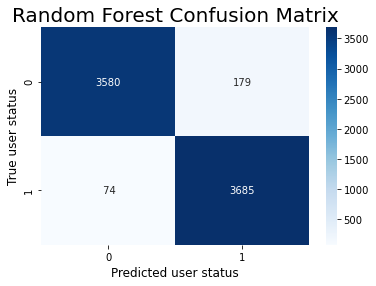

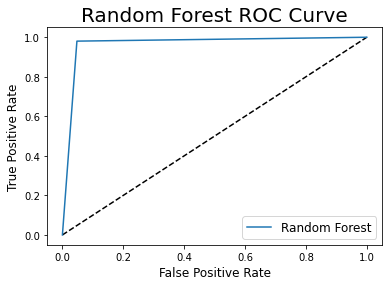

In [24]:
model_name = 'Random Forest'
       
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='word',lowercase=False, ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

parameters = {
    'vect__max_df': (0.25,0.5, 0.75),
    'clf__criterion': ('gini','entropy'),
    'clf__max_features': ('auto', 'sqrt'),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

y_pred = grid_search.predict(X_test)
results = results.append(metrics(model_name,y_test,y_pred))

## 4.9 Data quantity assessment<a id='4.9_Data_quantity_assessment'></a>

In [25]:
fractions = [0.25, 0.35, 0.5, 0.75, 1.0]
train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

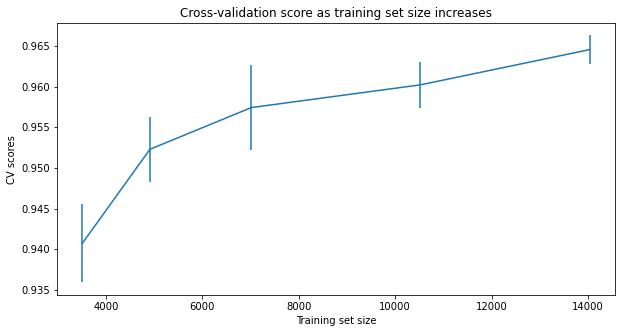

In [26]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## 4.10 Save best model object from pipeline<a id='4.10_Save_best_model_object_from_pipeline'></a>

In [27]:
#import sklearn.externals.joblib as extjoblib
import joblib
import pickle
joblib.dump(grid_search.best_estimator_, 'best_model_version1.2.pkl', compress = 1)

['best_model_version1.2.pkl']

## 4.11 Feature Importance

In [28]:
pipeline = joblib.load('best_model_version1.2.pkl')

In [29]:
imps = pipeline.named_steps['clf'].feature_importances_
fi = {'Importance':imps}
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

In [30]:
a = pipeline.named_steps['vect'].get_feature_names()

In [31]:
index = []
for i in Importance.index:
    term = a[i]
    index.append(term)

In [32]:
terms = pd.DataFrame({'Term': index, 'Position': Importance.index,'Importance': Importance.Importance})

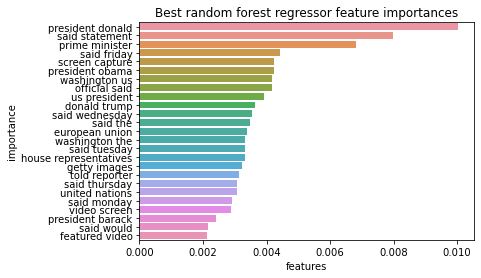

In [34]:
 _ = sns.barplot(y = 'Term', x='Importance',data=terms)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');







## 4.11 Summary<a id='4.11_Summary'></a>

From the 4 models it is observed that the exception of Naive Bayes all of them have very few mis-classification. The ROC_AUC score is 0.964 which is exceptionally well for text classification.  
    
   * The top three models are Logistic Regression, Stochastic Gradient Descent and Random Forest

   * Random Forest, SGD and Logistic Regression has comparable ROC-AUC score. Although Logistic Regression has the highest ROC-AUC score it trained only a max_df = 0.25. This means the modeled ignored terms that have a document frequency strictly lower than the given threshold. However, Random Forest is more scalable, and interpretable and also performs better with noisy data. Considering these, we chose Random Forest as the best model. 

   * Feature Importance of the model shows that 'president Donald Trump', Washington' 'President Obama' were given the highest importance. This is in alignment with the fact that this dataset is indeed a repersentation of the news during the 2016 US Presidential Election.

Although the model performance is very good, looking at both the feature importance of the model the n-gram analysis from EDA  it can be inferred that the data is biased towards US Presidential Election and any news outside this scope might be difficult for the model to predict. We need a bigger dataset covering a wide range of news for both TRUE and FAKE labels to make a more generalized model. 